In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
from IPython.display import display
import textwrap
import json 
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

## Import speech dataset and preprocessed data for lda

In [3]:
filename = "data/csv/speech_output.csv"

df = pd.read_csv(filename)
df["year"] = df.apply(lambda s: int(s["date"][:4]), axis=1)
df["uq_agenda"] = df["agenda"]+df["date"]

/var/folders/6q/pqc7tgjx0_nfs5rp04gzmt640000gn/T/ipykernel_19190/488462102.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [16]:
# import preprocessed data: tokenization, lemmatization, stopword removal
preprocessed_data = json.load(open("data/lda/preprocessed_texts.json"))

## Adjust party variable

In [ ]:
# remove all speakers without clear political affiliation:

# only use speeches where speaker is associated with a party
df_party_members = df[~(df["party"] == "-")]
# remove non-inscrits: no party group affiliation
# df_party_members = df_party_members[~(df_party_members["party"] == "NI")]
# remove TGI: technical group of independents, no party group affiliation
# df_party_members = df_party_members[~(df_party_members["party"] == "TGI")]
print(len(df_party_members))

479496


In [ ]:
# merge parties that changed names over time
df_party_members['party_adj'] = df_party_members['party']  # start with a copy

df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_adj'] = 'PSE/S&D' # PSE becomes S&D
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_adj'] = 'PPE' # PPE-DE' becomes 'PPE'
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD']), 'party_adj'] = 'EFD' # 'EFDD' becomes 'EFD'
df_party_members.loc[df_party_members['party'].isin(['ITS', 'ENF', 'ID']), 'party_adj'] = 'ENF/ID' # ENF becomes ID in 2019
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_adj'] = 'ELDR/ALDE/Renew' # ELDR becomes ALDE becomes Renew
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_adj'] = 'NGL/The Left' # GUE/NGL becomes The Left
df_party_members.loc[df_party_members['party'].isin(['IND/DEM','EDD']), 'party_adj'] = 'INDDEM/EDD' # independents become EDD

# print information
display(df_party_members["party_adj"].value_counts())

party_adj
PPE                162619
PSE/S&D            119544
NGL/The Left        46548
ELDR/ALDE/Renew     42631
ECR                 29243
Greens/EFA          26278
EFD                 22197
ENF/ID              20827
UEN                  5173
INDDEM/EDD           4436
Name: count, dtype: int64

In [7]:
# add column: party block
df_party_members['party_block'] = df_party_members['party']  # start with a copy

# left
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_block'] = 'left'
# green
df_party_members.loc[df_party_members['party'].isin(['Greens/EFA']), 'party_block'] = 'greens'
# social democratic
df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_block'] = 'social_democratic'
# christian conservative
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_block'] = 'christian_conservative'
# liberal
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_block'] = 'liberal'
# right populist
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD','ITS', 'ENF', 'ID', 'IND/DEM', 'ECR', 'UEN', 'EDD']), 'party_block'] = 'right_populist'

# print information
display(df_party_members["party_block"].value_counts())

party_block
christian_conservative    162619
social_democratic         119544
right_populist             81876
left                       46548
liberal                    42631
greens                     26278
Name: count, dtype: int64

In [8]:
# save df_party_members to csv
# df_party_members.to_csv("data/csv/speech_output_parties.csv", index=False)

### We still need to translate speeches post 2019: how many? 

In [9]:
df_untranslated = df_party_members[df_party_members["translatedText"].isna()]
df_untranslated.head()

# compute number of speeches to be translated
num_speeches = df_untranslated.shape[0]
print(f"Number of speeches to be translated: {num_speeches}")

# compute number of speeches already translated
num_speeches_translated = df_party_members.shape[0]
print(f"Number of speeches already translated: {num_speeches_translated}")

# compute number of characters in untranslated speeches
total_chars = df_untranslated["text"].apply(len).sum()
print(f"Total characters to be translated: {total_chars}")

total_chars_translated = df_party_members["text"].apply(len).sum()
print(f"Total characters already translated: {total_chars_translated}")

Number of speeches to be translated: 49296
Number of speeches already translated: 479496
Total characters to be translated: 68373204
Total characters already translated: 554314120


In [14]:
# for now: only use speeches which were given in english or machine translation availible
df_party_members = df_party_members[df_party_members["translatedText"].notna()]

# only keep speeches with at least 50 characters: important for coherence with preprocessed data
df_party_members = df_party_members[df_party_members["translatedText"].map(len) > 50]
print(len(df_party_members))
print(len(preprocessed_data))

429811
100


In [ ]:
# synchronize preprocessed_data with df_party_members by filtering to matching indices
# create a boolean mask based on the original df indices
# original_indices = df.index.tolist()
# kept_indices_set = set(df_party_members.index.tolist())
# mask = [i in kept_indices_set for i in original_indices]
# preprocessed_data = [preprocessed_data[i] for i, keep in enumerate(mask) if keep]
# print(f"Filtered preprocessed_data to {len(preprocessed_data)} entries")
# print(f"df_party_members has {len(df_party_members)} rows")
# print(f"Lengths match: {len(preprocessed_data) == len(df_party_members)}")

# df_party_members = df_party_members.reset_index(drop=True)

IndexError: list index out of range

In [ ]:
df_party_members = df_party_members.reset_index(drop=True)

## LDA: Define 80 (for now) topics and assign their probabilities to each speech

In [29]:
print("creating dictionary")
dictionary = corpora.Dictionary(preprocessed_data)
print("filtering dictionary")
dictionary.filter_extremes(
    no_below=10,     # Keep tokens appearing in at least 10 docs
    no_above=0.4,    # Remove tokens appearing in more than 40% of docs
    keep_n=100000    # Keep only the top 100k words by frequency
)
corpus = [dictionary.doc2bow(l) for l in tqdm(preprocessed_data, "Preparing corpus")]

creating dictionary
filtering dictionary


Preparing corpus: 100%|██████████| 453412/453412 [00:23<00:00, 19542.05it/s]


In [30]:
def print_topics(model, n_topics, k_words=5):
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx + 1}: {label}")

In [31]:
def assign_topics(lda_model, corpus):
    # choose the LDA model to use (change if you want a different one)
    topics = []
    for bow in tqdm(corpus, desc="Assigning most probable topic to each doc"):
        docs_topics = lda_model.get_document_topics(bow, minimum_probability=0)
        topics.append(docs_topics)
    return topics

## Assign topics to speeches using pre-trained model

In [32]:
n_topics = 80
model = LdaModel.load(f"data/lda/{n_topics}_topics/model.model")

corpus_topics = assign_topics(model, corpus)

Assigning most probable topic to each doc: 100%|██████████| 453412/453412 [01:43<00:00, 4377.37it/s]


In [33]:
# print list of topics
print_topics(model, n_topics)

Topic 1: kosovo, america, serbia, american, latin
Topic 2: waste, export, arm, material, weapon
Topic 3: ro, candidate, member, appointment, appoint
Topic 4: money, eu, spend, taxpayer, use
Topic 5: discrimination, roma, anti, racism, community
Topic 6: da, scandal, stem, indonesia, false
Topic 7: food, ban, commission, modify, use
Topic 8: russia, political, country, election, ukraine
Topic 9: language, minority, religious, christian, ethnic
Topic 10: euro, economic, country, crisis, greece
Topic 11: citizen, institution, initiative, transparency, union
Topic 12: population, city, people, urban, live
Topic 13: committee, affair, petition, parliament, work
Topic 14: woman, man, equality, gender, equal
Topic 15: french, france, lesson, learn, india
Topic 16: agreement, eu, union, trade, cooperation
Topic 17: member, state, convention, union, parliament
Topic 18: investment, project, fund, development, research
Topic 19: regulation, directive, proposal, commission, legal
Topic 20: mr, li

In [34]:
# corpus topics is a list of lists of (topic_id, probability) tuples for each document in the corpus
# turn this list into dataframe of size (num_docs, num_topics) with probabilities
num_docs = len(corpus_topics)
num_topics = n_topics
topic_prob_matrix = np.zeros((num_docs, num_topics))
for doc_idx, doc_topics in enumerate(corpus_topics):
    for topic_id, prob in doc_topics:
        topic_prob_matrix[doc_idx, topic_id] = prob
topic_prob_df = pd.DataFrame(topic_prob_matrix, columns=[f"topic_{i}" for i in range(num_topics)])
topic_prob_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79
0,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.091517,0.000066,0.000066,0.000066,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.146100,0.016427,0.059039
1,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,...,0.164257,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.122448,0.000094,0.400441
2,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.132823,0.000089,0.000089,0.000089,...,0.051904,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.244603,0.025695,0.273211
3,0.000078,0.008323,0.000078,0.000078,0.000078,0.000078,0.160490,0.000078,0.000078,0.000078,...,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.370459
4,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.123911,0.000085,0.000085,0.000085,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.283541,0.000085,0.257963


In [35]:
# append topic probabilities to df_party_members
df_topics = pd.concat([df_party_members.reset_index(drop=True), topic_prob_df], axis=1)
df_topics.head()

,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79
0,Julie Girling,"Mr President, I’m actually speaking today on b...",PPE,2019-04-18,3. A comprehensive European Union framework on...,3.0,,6398.0,8.0,False,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.146100,0.016427,0.059039
1,Miriam Dalli,"Mr President, postponing concrete action to re...",S&D,2019-04-18,3. A comprehensive European Union framework on...,4.0,,6399.0,8.0,False,...,0.164257,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.122448,0.000094,0.400441
2,Frédérique Ries,"Monsieur le Président, je siège dans cet hémic...",ALDE,2019-04-18,3. A comprehensive European Union framework on...,5.0,,6401.0,8.0,False,...,0.051904,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.244603,0.025695,0.273211
3,Kateřina Konečná,"Pane předsedající, já myslím, že je smutné, že...",GUE/NGL,2019-04-18,3. A comprehensive European Union framework on...,6.0,,6402.0,8.0,False,...,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.370459
4,Michèle Rivasi,"Monsieur le Président, Madame la Commissaire, ...",Greens/EFA,2019-04-18,3. A comprehensive European Union framework on...,7.0,,6403.0,8.0,False,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.283541,0.000085,0.257963


### Extract migration speeches: those that exceed a certain probability threshold (0.2 for now) for topic 26

In [36]:
# get migration dataset
topic_id_migration = 26
prob_threshold = 0.3
df_migration = df_topics[df_topics[f"topic_{topic_id_migration}"] >= prob_threshold]
print(f"Number of speeches related to migration (topic {topic_id_migration} with prob >= {prob_threshold}): {df_migration.shape[0]}")

Number of speeches related to migration (topic 26 with prob >= 0.3): 7410


### Test: Display migration speeches with lowest probability that is still above threshold

In [37]:
df_migration_sorted = df_migration.sort_values(by=f"topic_{topic_id_migration}")
speech_number = 10
for idx, row in df_migration_sorted.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Year: 2006.0, Topic Probability: 0.3000
(NL) Mr President, the destabilising effects of Pyongyang’s nuclear test last Monday are evident,
particularly in North-East Asia, but also globally. We are now facing two nuclear crises: an acute
one in North-Korea, and an urgent one in Iran. The question is whether both remain manageable
without military means, and the attitude of two members of the UN Security Council, namely China and
Russia, is of decisive importance in this respect. What importance do Beijing and Moscow still
attach to the Non-Proliferation Treaty? Their conduct in the Security Council will tell. I expect
the Member States of the EU, sitting, as they do, on this high-level UN body, to insist on reminding
China and Russia of their crucial responsibility in this. Meanwhile, what matters is that the
international community should keep tabs on Pyongyang’s trade activities, especially the maritime
routes. Indeed, only last week, the North Korean regime announced that it is suppl

AttributeError: 'float' object has no attribute 'expandtabs'

### Test: Display speeches with highest probability

In [ ]:
df_migration_sorted = df_migration.sort_values(by=f"topic_{topic_id_migration}", ascending=False)
speech_number = 10
for idx, row in df_migration_sorted.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Year: 2015, Topic Probability: 0.9530
I supported. The last weeks have shown that the European asylum system is not working as it should.
Europe has not been able to humanely deal with war refugees, but the refugee crisis is manageable
and the European Union can handle it humanely if all countries help.

----------------------------------------------------------------------------------------------------

Year: 2016, Topic Probability: 0.9506
Given the current number of asylum seekers in Greece and the increasing number of asylum seekers
arriving in Italy, I believe that there will remain a high demand for emergency relocation places.

----------------------------------------------------------------------------------------------------

Year: 2015, Topic Probability: 0.9395
Despite the ongoing flow of refugees, some member states are still refusing European coordination
and a fair distribution of these people seeking protection within Europe. Greece, Italy and Hungary
are overwhelmed wit

In [ ]:
# save migration data to csv
df_migration_sorted.to_csv("migration_speeches_lda.csv", sep="\t")


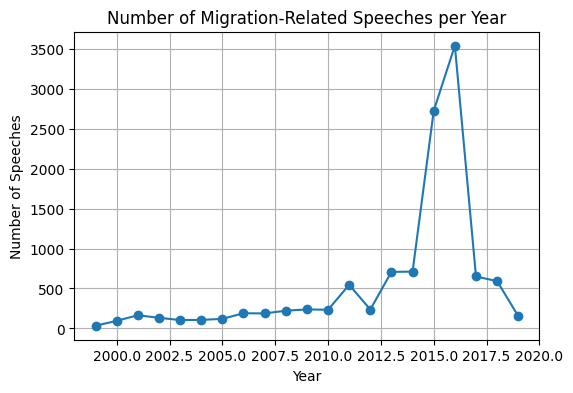

In [ ]:
# plot number of migration speeches per year
migration_counts_per_year = df_migration['year'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.plot(migration_counts_per_year.index, migration_counts_per_year.values, marker='o')
plt.title('Number of Migration-Related Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.grid()
plt.show()

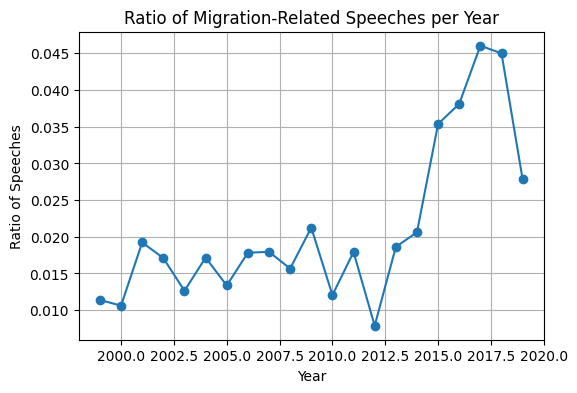

In [ ]:
# normalized plot: ratio of migration speeches to total speeches per year
speech_counts_per_year = df_party_members['year'].value_counts().sort_index()
ratio_per_year = migration_counts_per_year / speech_counts_per_year
plt.figure(figsize=(6, 4))
plt.plot(migration_counts_per_year.index, ratio_per_year, marker='o')
plt.title('Ratio of Migration-Related Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Ratio of Speeches')
plt.grid()
plt.show()

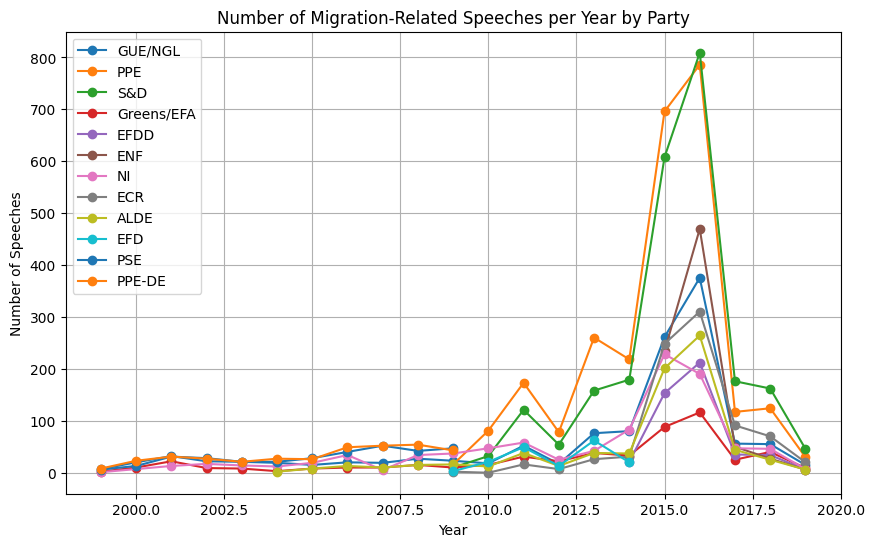

In [ ]:
# plot number of migration speeches per year, separated by party
parties = df_migration['party'].unique()

# exclude parties with very few speeches
speech_cutoff = 100
parties = [party for party in parties if df_migration[df_migration['party'] == party].shape[0] >= speech_cutoff]
plt.figure(figsize=(10, 6))
for party in parties:
    party_data = df_migration[df_migration['party'] == party]
    counts_per_year = party_data['year'].value_counts().sort_index()
    plt.plot(counts_per_year.index, counts_per_year.values, marker='o', label=party)
plt.title('Number of Migration-Related Speeches per Year by Party')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend()
plt.grid()
plt.show()

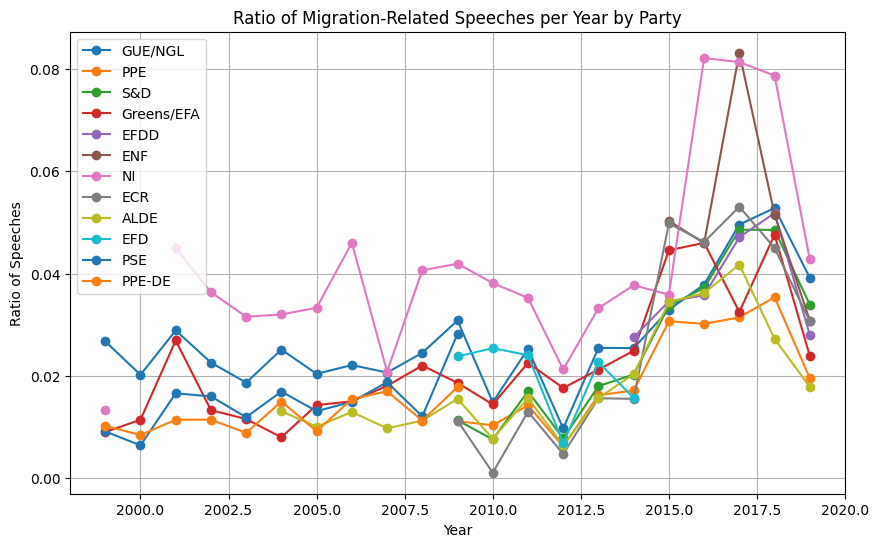

In [ ]:
# normalized plot: ratio of migration speeches to total speeches per year, separated by party
plt.figure(figsize=(10, 6))
for party in parties:
    party_data = df_migration[df_migration['party'] == party]
    counts_per_year = party_data['year'].value_counts().sort_index()
    total_counts_per_year = df_party_members[df_party_members['party'] == party]['year'].value_counts().sort_index()
    ratio_per_year = counts_per_year / total_counts_per_year
    plt.plot(ratio_per_year.index, ratio_per_year.values, marker='o', label=party)
plt.title('Ratio of Migration-Related Speeches per Year by Party')
plt.xlabel('Year')
plt.ylabel('Ratio of Speeches')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# TODO: look at Topic 68: border, cooperation, crime, state, member
# -> proably more related to europol and international terrorism, smugglery etc.

## Old approach: Use Keyword search to find relevant agendas / speeches

In [ ]:
# keywords = ["(M|m)igration", "(M|m)igrant", "(R|r)efugee", "(A|a)sylum", "(T|t)hird(-)?country national"]#, "(F|f)rontex"]
# indices_keyword_identified_speeches = df_party_members.index[df_party_members["uq_agenda"].str.contains("|".join(keywords))].tolist()
# TODO: potentially find relevant keywords using word2vec over text and look for words similar to migration? 

In [ ]:
# def filter_for_keywords(df, column="agenda", keywords=keywords, min_contributions_per_agenda_item=10): 
#     relevant_indices = df[column].str.contains("|".join(keywords))
#     agenda_items_vc = df[relevant_indices]["uq_agenda"].value_counts()
    
#     # TODO: do this filtering in the beginning because why not
#     n_agenda_items_before = len(agenda_items_vc)
#     relevant_agendas = agenda_items_vc[agenda_items_vc > min_contributions_per_agenda_item]
#     n_agenda_items_after = len(relevant_agendas)
#     print(f"filtered {n_agenda_items_before-n_agenda_items_after} agenda items with < {min_contributions_per_agenda_item} speeches")
    
#     relevant_indices = relevant_indices & (df["uq_agenda"].isin(relevant_agendas.index))
    
#     print(f"n speeches: {len(df[relevant_indices])}")
#     print(f"n agendas: {n_agenda_items_after}")
    
#     return df[relevant_indices]

In [ ]:
# # agenda items per year; speech per year; 
# # party per agenda item
# # contribution per party per year
# # normalize by original 
# df_filtered = filter_for_keywords(df)

In [ ]:
# n_per_year_and_party = df_filtered.groupby(["year"]).size()#.unstack()

# ax = n_per_year_and_party.plot(kind="bar", stacked=False, figsize=(40, 5))
# shortened_labels = [l[:50]+"..." if len(l) > 50 else l for l in [lb.get_text() for lb in ax.get_xticklabels()]]
# _ = ax.set_xticklabels(shortened_labels)

In [ ]:
# vc = df_filtered["uq_agenda"].value_counts()
# vc

In [ ]:
# df_filtered_text = filter_for_keywords("text")

In [ ]:
# n = df_filtered_text["uq_agenda"].value_counts()
# print(n.min(), n.mean(), n.max())

# #df_filtered["uq_agenda"]
# print(len(n))
# # agendas that with more than 4 speeches with relevant keywords, that are not in the agendas that were discovered with keywords in title
# new_relevant_agendas = n[(n>4) & (~n.index.isin(df_filtered["uq_agenda"]))]
# new_relevant_agendas[:20]

In [ ]:
# def print_agenda(search_term, n_speeches=None): 
#     all_agendas = df[df["uq_agenda"].str.contains(search_term)]["uq_agenda"].unique()
#     for agenda in all_agendas: 
#         speeches = df[df["uq_agenda"] == agenda].sort_values(by="speechnumber", ascending=True)
#         print("Agenda:", (agenda[:30]+"..." if len(agenda) > 30 else agenda))
#         print("Nr of speeches:", len(speeches))
#         print("")
        
#         if n_speeches:
#             speeches = speeches[:n_speeches]
#         for _, r in speeches.iterrows(): 
#             print(f'({r["speechnumber"]}) {r["speaker"]} ({r['party']}): {r['text'] if not r['translatedText'] else r["translatedText"]}')

In [ ]:
# print_agenda("6.4. Situation of fundamental rights in the European Union in 2015", 10)
# print_agenda("7.7. The situation of women refugees and asylum seekers in the EU", 10)
# print_agenda("European Border and Coast Guard", 10)

## Model evaluation

In [ ]:
# def evaluate_model(lda_model, dictionary, compute_coherence=True): 
#     if compute_coherence: 
#         print("Computing coherence")
#         coherence_model = CoherenceModel(
#             model=lda_model, 
#             texts=preprocessed_data, 
#             dictionary=dictionary, 
#             coherence='c_v'  # most common coherence measure
#         )
#         coherence_score = coherence_model.get_coherence()
#         print("Coherence:", coherence_score)
#     else: 
#         coherence_score = None 
        
#     # compute which topics are related to migration 
#     migration_topic_indices = lda_model.get_term_topics(lda_model.id2word.token2id["migration"], minimum_probability=0)
#     print("Topics related to 'migration':", len(migration_topic_indices))
    
#     # check if any migration-related topic has probability > 0.05 (arbitrary threshold)
#     threshold = 0.05
#     high_topics = [(tid, prob) for tid, prob in migration_topic_indices if prob > threshold]
#     if len(high_topics) > 0:
#         print(f"Topics with probability > {threshold}: {high_topics}")
#     else:
#         print(f"No migration-related topic has probability > {threshold}")

#     # for each speech with migration-keyworded agenda, get most probable topic
#     topic_counts = Counter()
#     topic_probabilities = []
#     missmatches = 0 
#     for idx in indices_keyword_identified_speeches:
#         # if idx >= len(preprocessed_data):
#         #     break
#         bow = dictionary.doc2bow(preprocessed_data[idx])
#         topic_distribution = lda_model.get_document_topics(bow)
#         most_probable_topic = max(topic_distribution, key=lambda x: x[1])
#         topic_counts[most_probable_topic[0]] += 1
#         topic_probabilities.append(most_probable_topic[1])

#         if most_probable_topic[0] not in dict(migration_topic_indices):
#             missmatches += 1 # count how often the most probable topic is not a migration-related topic

#     print("Most common topics for migration-related speeches:", topic_counts.most_common(len(migration_topic_indices)))
#     print("Average probability of most probable topic for migration-related speeches:", sum(topic_probabilities) / len(topic_probabilities))
#     print("missmatches (most probable topic not migration-related):", missmatches, f"{missmatches / len(indices_keyword_identified_speeches):.2%}")

#     return len(high_topics), coherence_score, missmatches

In [ ]:
# n_topic_values = [90, 100, 120]
# n_workers = 8

# import os 
# for n_topics in n_topic_values: 
#     os.makedirs(f"lda/{n_topics}_topics", exist_ok=True)
#     out_path = f"lda/{n_topics}_topics/model.model"
#     num_topics = n_topics
#     n_passes = 5
#     workers = n_workers

#     print("Fitting model with", num_topics, "topics and", n_passes, "passes")
#     lda_model = LdaMulticore(corpus = corpus, id2word=dictionary, num_topics = num_topics, passes = n_passes, workers=workers)
#     lda_model.save(out_path)

#     # Evaluate model
#     evaluate_model(lda_model, dictionary)

### Old Function: Count topic assignments

In [ ]:
# def count_topic_assignments(corpus_topics, topic_id, prob_threshold=0.0):
#     total = 0
#     most_prob_count = 0
#     at_least_prob_count = 0

#     most_doc_indices = [] 

#     most_probabilities = []
#     at_least_probabilites = []
#     for i, doc_topics in tqdm(enumerate(corpus_topics), desc="Counting topic assignments"):
#         # skip empty entries
#         if not doc_topics:
#             continue
#         total += 1

#         most_topic, most_prob = max(doc_topics, key=lambda x: x[1])
#         if most_topic == topic_id:
#             most_prob_count += 1
#             most_probabilities.append(most_prob)
#             most_doc_indices.append(i)

#         # probability of the target topic (0.0 if absent)
#         prob_map = dict(doc_topics)
#         prob = prob_map.get(topic_id, 0.0)
#         if prob >= prob_threshold:
#             at_least_prob_count += 1
#             at_least_probabilites.append(prob)

#     if total == 0:
#         return ({
#             "total_docs": 0,
#             "most_prob_count": 0,
#             "at_least_prob_count": 0,
#             "most_avg_prob": 0.0, 
#             "at_least_avg_prob": 0.0,
#         }, [], [])

#     return ({
#         "total_docs": total,
#         "most_prob_count": most_prob_count,
#         "at_least_prob_count": at_least_prob_count, 
#         "most_avg_prob": sum(most_probabilities) / most_prob_count,
#         "at_least_avg_prob": sum(at_least_probabilites) / at_least_prob_count,  
#     }, most_doc_indices, most_probabilities)